In [18]:
import cv2
import fitz  # PyMuPDF
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import re
from PIL import Image
import numpy as np
import requests
import base64
from io import BytesIO
from IPython.display import display, Image as IPythonImage

In [19]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [20]:
# Function to convert PDF to images
def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    return images

# Function to preprocess images for better OCR accuracy
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Denoise the image
    denoised = cv2.fastNlMeansDenoising(binary, None, 30, 7, 21)
    
    return denoised

# Function to extract text from images using Tesseract OCR
def ocr_text(image):
    text = pytesseract.image_to_string(image, config='--psm 6')
    return text

# Function to extract mathematical expressions using MathPix API
def ocr_math(image, app_id, app_key):
    _, encoded_image = cv2.imencode('.png', image)
    b64_image = base64.b64encode(encoded_image).decode('utf-8')

    headers = {
        'app_id': app_id,
        'app_key': app_key,
        'Content-Type': 'application/json'
    }
    data = {
        'src': f'data:image/png;base64,{b64_image}',
        'formats': ['text']
    }

    response = requests.post('https://api.mathpix.com/v3/text', json=data, headers=headers)
    response_data = response.json()

    return response_data.get('text', '')

# Function to combine text and mathematical OCR results
def combine_text_and_math(text, math_text):
    combined_text = f"{text}\n{math_text}"
    return combined_text

# Main function to process PDF and extract text
def process_pdf(pdf_path, app_id, app_key):
    images = pdf_to_images(pdf_path)
    results = []

    for image in images:
        preprocessed_image = preprocess_image(image)
        text = ocr_text(preprocessed_image)
        math_text = ocr_math(preprocessed_image, app_id, app_key)
        combined_text = combine_text_and_math(text, math_text)
        results.append(combined_text)

    return results

# Function to parse the extracted text and convert it to a dictionary
def parse_text_to_dict(texts):
    data = {
        'Question_ID': [],
        'Skill': [],
        'Correct Answer': [],
        'Question Difficulty': [],
        'Question Image': [],
        'Question Image2': [],
        'Rationale Image': [],
        'Rationale Image2': []
    }

    current_section = None
    skill_text = ""

    for text in texts:
        lines = text.splitlines()
        for line in lines:
            if re.match(r"^Question ID\s*\s*", line):
                data['Question_ID'].append(line.split(" ")[-1].strip())
                current_section = 'Question_ID'
            elif re.match(r"^SAT Math\s*\s*", line):
                skill_text += line.strip() + " "
                current_section = 'Skill'
            elif re.match(r"^Correct\s*Answer\s*:\s*", line):
                data['Correct Answer'].append(line.split(": ")[-1].strip())
                current_section = 'Correct Answer'
            elif re.match(r"^Question\s*Difficulty\s*:\s*", line):
                data['Question Difficulty'].append(line.split(": ")[-1].strip())
                current_section = 'Question Difficulty'
            else:
                if current_section == 'Skill':
                    skill_text += line.strip() + " "
                    current_section = 'next'
        
        data['Skill'].append(skill_text.strip())
        skill_text = ""  # Reset skill_text for the next entry

    
    # Ensure all lists have the same length by adding empty strings where necessary
    max_length = max(len(data[col]) for col in data)
    for col in data:
        while len(data[col]) < max_length:
            data[col].append("")
            
    return data

# Function to find the coordinates of the text in the PDF
def find_text_coordinates(pdf_path, search_text):
    pdf_document = fitz.open(pdf_path)
    
    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        search_results = page.search_for(search_text)
        
        if search_results:
            return search_results, page_number
    
    return None, None

# Function to extract a section of the PDF as an image
def extract_pdf_section(pdf_path, page_number, rect):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number)
    pix = page.get_pixmap(clip=rect)
    
    # Convert to image
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    return image

In [41]:
pdf_path = 'SAT2.pdf'
app_id = 'your_app_id'
app_key = 'your_app_key'

# Convert PDF to images
images = pdf_to_images(pdf_path)

# Extract text from images using Tesseract OCR
texts = process_pdf(pdf_path, app_id, app_key)

# Parse the extracted text and convert it to a dictionary
data_dict = parse_text_to_dict(texts)

# Find the coordinates for the bounding box where the question is located
search_text = "Rationale"
coordinates, page_number = find_text_coordinates(pdf_path, search_text)
if coordinates:
    rect = fitz.Rect(5, 166, 600, coordinates[0].y1-65)
    question_image = extract_pdf_section(pdf_path, page_number, rect)
    data_dict['Question Image'][0] = question_image

    # Convert image to base64 string for storage in dictionary
    buffered = BytesIO()
    question_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    
    for i in range(len(data_dict['Question_ID'])):
        data_dict['Question Image2'][0] = img_str

search_text1 = "Rationale"
search_text2 = "Question Difficulty"
coordinates1, page_number = find_text_coordinates(pdf_path, search_text1)
coordinates2, page_number = find_text_coordinates(pdf_path, search_text2)
if coordinates1:
    rect = fitz.Rect(5, coordinates1[0].y1+10, 600, coordinates2[0].y1-20)
    rationale_image = extract_pdf_section(pdf_path, page_number, rect)
    data_dict['Rationale Image'][0] = rationale_image

    # Convert image to base64 string for storage in dictionary
    buffered = BytesIO()
    rationale_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    
    for i in range(len(data_dict['Question_ID'])):
        data_dict['Rationale Image2'][0] = img_str

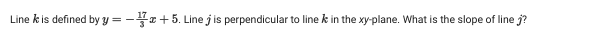

In [42]:
data_dict['Question Image'][0]

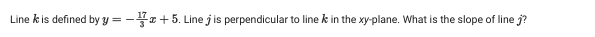

In [16]:
if data_dict['Question Image2']:
        img_data = base64.b64decode(data_dict['Question Image2'][0])
        display(IPythonImage(data=img_data))

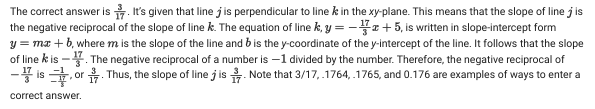

In [15]:
data_dict['Rationale Image'][0]

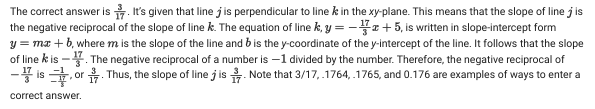

In [18]:
if data_dict['Rationale Image2']:
        img_data = base64.b64decode(data_dict['Rationale Image2'][0])
        display(IPythonImage(data=img_data))

In [19]:
# Convert dictionary to DataFrame and save as CSV
df = pd.DataFrame(data_dict)
df.to_csv('SAT_Question_Bank_Results.csv', index=False)